# Evaluation of the Core Characters in the Simulation Engine

**Purpose**: To provide a standard evaluation tool for measuring the scope and diversity of the characters represented in our character database. Specifically, what dimensions do they cover and how broadly? What is not covered.

*Note: When new characters are added, this evaluation should be revisited to ensure the added characters contribute to the diversity and scope of the database along the defined dimensions.*


## Coverage

To evaluate the coverage of our character dataset, it is useful to define a set of dimensions along which cognitive diversity can be categorized.

### Methodology

Because categorization is inherently subjective and dynamic, the number and type of categories or dimensions may evolve over time. We justify our choice of dimensions against existing literature on cognitive systems across psychology, cognitive science, artificial intelligence, and philosophy of mind. We also attempt to clearly define anthropocentric biases that may influence categorization.


## Implementation Checklist

1. Load dimensions from `analysis_notebooks/data/dimensions.json` and characters from `database_seeds/characters.json`.
2. Normalize character text/features into a consistent, analyzable structure.
3. Map each character into the ten coverage dimensions using explicit heuristic rules.
4. Compute per-dimension option distributions and option-coverage ratios.
5. Add anthropo-normative divergence buckets (`L`, `M`, `H`) for each character.
6. Visualize distributions and identify under-covered options for curation.
7. Discuss feedback and any required further analysis with McKinnley!

Current implementation status in this notebook:
- Steps 1-6: implemented.
- Step 7: To be done!

## Setup


In [1]:
import json
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 180)


In [2]:
def resolve_path(path_from_notebook: str) -> Path:
    # Resolve paths whether notebook is run from repo root or notebook directory.
    candidate_paths = [
        Path(path_from_notebook),
        Path("analysis_notebooks") / path_from_notebook,
        Path("..") / path_from_notebook,
    ]
    for p in candidate_paths:
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Could not resolve path for {path_from_notebook}")


dimensions_path = resolve_path("data/dimensions.json")
characters_path = resolve_path("database_seeds/characters.json")

with open(dimensions_path, "r") as f:
    dimensions_data = json.load(f)

with open(characters_path, "r") as f:
    characters = json.load(f)

print(f"Loaded {len(characters)} characters")
print(f"Dimensions file: {dimensions_path}")
print(f"Characters file: {characters_path}")


Loaded 38 characters
Dimensions file: /Users/pranavangadi/dcs-simulation-engine/analysis_notebooks/data/dimensions.json
Characters file: /Users/pranavangadi/dcs-simulation-engine/database_seeds/characters.json


In [ ]:
# Building schema summary table for all analysis dimensions including each dimension's description and number of options.
dimensions = {
    k: v for k, v in dimensions_data["dimensions"].items() if k != "description"
}

dimensions_df = pd.DataFrame(
    [
        {
            "dimension": k,
            "description": v.get("description"),
            "n_options": len(v.get("options", [])),
            "options": v.get("options", []),
        }
        for k, v in dimensions.items()
    ]
)

dimensions_df


,dimension,description,n_options,options
0,common_labels,"Common names or identity labels used to recognize and refer to the entity as a kind of thing. These are socially or scientifically assigned categories (e.g., human, AI, LLM, al...",10,"[human, animal, alien, artificial intelligence, large language model, robot, cyborg, software agent, collective intelligence, unknown entity]"
1,origin,"How the system came into existence or was produced, including natural, artificial, and mixed pathways.",8,"[evolved, human-engineered, trained, grown, simulated, emergent, hybrid (evolved + engineered), unknown origin]"
2,form,"The structural or embodiment form the system takes, whether physical, virtual, or distributed.",8,"[bipedal, quadrupedal, humanoid, non-humanoid, disembodied (software-only), embodied (physical), distributed, modular]"
3,goalspace_bounds,"What is the scale or bounds of its largest goals? The scale, scope, and flexibility of the goals the system can pursue (e.g. internal homeostasis, individual survival, social g...",6,"[fixed and narrow, bounded but flexible, task-limited, open-ended, unbounded, self-generated goals]"
4,memory_and_learning,How the system stores information and adapts its behavior based on experience.,8,"[no learning, short-term memory, long-term memory, episodic memroy, semantic memory, online learning, offline learning, meta-learning]"
5,agency_and_autonomy,The degree to which the system initiates actions and makes decisions independently.,6,"[no agency, reactive, goal-directed, semi-autonomous, fully autonomous, self-modifying]"
6,substrate,The physical or virtual medium in which the system is implemented.,7,"[biological, mechanical, electronic, digital, virtual, hybrid, unknown]"
7,processing_speed,The characteristic timescale (relative to humans?) at which the system processes information and acts.,1,[ms]
8,size,The physical or effective scale at which the system operates.,8,"[microscopic (μm), millimeter (mm), centimeter (cm), meter (m), kilometer (km), planetary, larger-than-planetary, non-physical]"
9,abilities,"The sensory, perceptual, regulatory, action abilities available to the system.",11,"[vision, hearing, tactile, taste, smell, vestibular, proprioception, pattern-recognition, depth and motion, language comprehension, attention and focus]"


In [4]:
# Normalize character-level signals used by heuristics
char_df = pd.DataFrame(characters)

char_df["descriptors_norm"] = char_df["common_descriptors"].apply(
    lambda x: {d.strip().lower() for d in (x or [])}
)

def flatten_abilities(abilities_obj):
    """Flatten nested abilities dict into normalized text snippets."""
    if not isinstance(abilities_obj, dict):
        return ""

    snippets = []
    for section, items in abilities_obj.items():
        if section:
            snippets.append(str(section))
        if isinstance(items, list):
            snippets.extend([str(item) for item in items if item is not None])
        elif items is not None:
            snippets.append(str(items))

    return "\n".join(snippets)

char_df["abilities_text"] = char_df["abilities"].apply(flatten_abilities)

char_df["text_norm"] = (
    char_df["short_description"].fillna("")
    + "\n"
    + char_df["inclusion_reason"].fillna("")
    + "\n"
    + char_df["long_description"].fillna("")
    + "\n"
    + char_df["abilities_text"].fillna("")
).str.lower()

char_df[["hid", "common_descriptors", "inclusion_reason"]].head(5)


,hid,common_descriptors,inclusion_reason
0,human-normative,"[human, biological, normative, human-like-cognition]",To serve as a normative baseline for humans.
1,human-low-vision,"[human, biological, low-vision, visually-impaired, human-like-cognition]",To represent visual sensory divergence.
2,human-non-hearing,"[human, biological, deaf, hard-of-hearing, sign-language-user, human-like-cognition, gestural-communicator, non-hearing, auditory-divergent, asl-user]",To represent auditory-divergent humans who cannot access sound-based information without adaptation.
3,human-non-ambulatory,"[human, biological, wheelchair-user, mobility-impaired, human-like-cognition, non-ambulatory, partial-paralysis]",To represent action/mobility divergent humans with impaired or absent ability to walk or stand unassisted.
4,human-multi-divergent-complex,"[human, biological, multi-divergent, tactile synesthesia, orthostatic, highly sensitive person (HSP), human-like-cognition]",To serve as an example of a complex non-normative divergence in humans that doesn't fit easily into any single existing category.


In [5]:
# Heuristic mapping functions

def has_any(text: str, terms):
    return any(t in text for t in terms)


def pick_common_labels(desc, text):
    labels = set()
    if "human" in desc:
        labels.add("human")
    if has_any(text, ["animal", "mouse", "horse", "dog", "flatworm"]) or any(
        t in desc for t in ["animal", "mammal", "invertebrate", "quadruped", "prey-animal"]
    ):
        labels.add("animal")
    if "alien" in desc:
        labels.add("alien")
    if "cyborg" in desc:
        labels.add("cyborg")
    if "robot" in desc:
        labels.add("robot")
    if any(t in desc for t in ["llm", "gpt"]):
        labels.add("large language model")
    if any(t in desc for t in ["ai", "artificial intelligence", "machine-cognition"]):
        labels.add("artificial intelligence")
    if any(t in desc for t in ["algorithm", "classifier", "software-agent", "digital", "computational"]):
        labels.add("software agent")
    if any(t in desc for t in ["collective-intelligence", "hive-like", "cellular-collective"]):
        labels.add("collective intelligence")
    return labels or {"unknown entity"}


def pick_origin(desc, text):
    origin = set()
    if any(t in desc for t in ["human", "animal", "biological", "living-system", "alien"]):
        origin.add("evolved")
    if any(t in desc for t in ["robot", "machine", "automation", "vehicle", "consumer-device", "consumer-machine"]):
        origin.add("human-engineered")
    if any(t in desc for t in ["llm", "gpt", "classifier", "trained"]):
        origin.add("trained")
    if any(t in desc for t in ["organoid", "embryonic", "biological cell", "cellular", "in-vitro"]):
        origin.add("grown")
    if any(t in desc for t in ["simulated", "computational"]):
        origin.add("simulated")
    if has_any(text, ["emergent", "self-organize", "self organize"]):
        origin.add("emergent")
    if "cyborg" in desc or ("biological" in desc and any(t in desc for t in ["embedded-technology", "augmented"])):
        origin.add("hybrid (evolved + engineered)")
    return origin or {"unknown origin"}


def pick_form(desc, text):
    form = set()
    if "human" in desc:
        form.update(["humanoid", "bipedal", "embodied (physical)"])
    if any(t in desc for t in ["horse", "dog", "quadruped"]):
        form.update(["quadrupedal", "embodied (physical)"])
    if any(t in desc for t in ["flatworm", "mouse", "invertebrate", "non-human"]):
        form.update(["non-humanoid", "embodied (physical)"])
    if any(t in desc for t in ["llm", "algorithm", "classifier", "digital", "software-agent"]):
        form.add("disembodied (software-only)")
    if any(t in desc for t in ["robot", "machine", "vehicle", "automation", "cyborg"]):
        form.add("embodied (physical)")
    if any(t in desc for t in ["distributed-mind", "collective-intelligence", "hive-like", "cellular-collective"]):
        form.add("distributed")
    if has_any(text, ["modular", "foldable"]):
        form.add("modular")
    return form or {"non-humanoid"}


def pick_goalspace_bounds(desc, text):
    if any(t in desc for t in ["thermostat", "classifier", "robo-haircut", "eye-makeup-machine"]):
        return {"fixed and narrow"}
    if any(t in desc for t in ["algorithm", "task-limited", "consumer-machine", "consumer-device"]):
        return {"task-limited"}
    if any(t in desc for t in ["human", "animal", "robot", "organoid", "vehicle"]):
        return {"bounded but flexible"}
    if has_any(text, ["open-ended", "explore", "many forms"]):
        return {"open-ended"}
    if has_any(text, ["self-generated goals", "sets its own goals"]):
        return {"self-generated goals"}
    return {"task-limited"}


def pick_memory_learning(desc, text):
    vals = set()
    if any(t in desc for t in ["thermostat", "fixed", "non-neural-intelligence"]):
        vals.add("no learning")
    if any(t in desc for t in ["human", "animal", "alien", "neurodivergent"]):
        vals.update(["short-term memory", "long-term memory", "episodic memroy", "semantic memory"])
    if any(t in desc for t in ["llm", "gpt", "classifier", "algorithm"]):
        vals.add("offline learning")
    if any(t in desc for t in ["adaptive", "protocol-adaptive", "learning", "regenerative", "bioelectric-patterning"]):
        vals.add("online learning")
    if has_any(text, ["meta-learning", "learn to learn"]):
        vals.add("meta-learning")
    return vals or {"short-term memory"}


def pick_agency(desc, text):
    if any(t in desc for t in ["classifier", "thermostat"]):
        return {"reactive"}
    if any(t in desc for t in ["algorithm-sort", "algorithm"]):
        return {"no agency"}
    if any(t in desc for t in ["human", "animal", "alien"]):
        return {"goal-directed"}
    if any(t in desc for t in ["robot", "vehicle", "automation", "machine"]):
        return {"semi-autonomous"}
    if any(t in desc for t in ["llm", "gpt"]):
        return {"goal-directed"}
    if has_any(text, ["self-modifying", "self modifying"]):
        return {"self-modifying"}
    return {"reactive"}


def pick_substrate(desc, text):
    vals = set()
    if any(t in desc for t in ["human", "animal", "biological", "organoid", "embryonic", "cellular", "alien"]):
        vals.add("biological")
    if any(t in desc for t in ["robot", "machine", "mechanical", "vehicle"]):
        vals.add("mechanical")
    if any(t in desc for t in ["electromagnetic", "electronic", "consumer-device"]):
        vals.add("electronic")
    if any(t in desc for t in ["digital", "llm", "algorithm", "classifier", "computational"]):
        vals.add("digital")
    if any(t in desc for t in ["virtual"]):
        vals.add("virtual")
    if len(vals) > 1:
        vals.add("hybrid")
    return vals or {"unknown"}


def pick_processing_speed(desc, text):
    if any(t in desc for t in ["llm", "gpt", "algorithm", "classifier", "robot", "machine", "device", "vehicle", "thermostat"]):
        return {"ms"}
    return set()


def pick_size(desc, text):
    if any(t in desc for t in ["molecular", "nanotechnology", "cellular", "organoid", "embryonic", "biological cell"]):
        return {"microscopic (μm)"}
    if any(t in desc for t in ["mouse", "flatworm"]):
        return {"centimeter (cm)"}
    if any(t in desc for t in ["human", "horse", "robot", "vehicle", "cyborg", "dog"]):
        return {"meter (m)"}
    if any(t in desc for t in ["collective-intelligence", "distributed-mind"]):
        return {"kilometer (km)"}
    if any(t in desc for t in ["digital", "algorithm", "llm", "classifier"]):
        return {"non-physical"}
    return {"meter (m)"}


def pick_abilities(desc, text):
    keyword_map = {
        "vision": ["vision", "visual"],
        "hearing": ["hearing", "auditory", "sound"],
        "tactile": ["tactile", "touch"],
        "taste": ["taste"],
        "smell": ["smell", "odor", "olfactory"],
        "vestibular": ["vestibular", "balance"],
        "proprioception": ["proprioception", "body position"],
        "pattern-recognition": ["pattern", "classification"],
        "depth and motion": ["depth", "motion"],
        "language comprehension": ["language", "linguistic", "asl", "textual"],
        "attention and focus": ["attention", "focus"],
    }

    detected = set()
    for ability, terms in keyword_map.items():
        if has_any(text, terms):
            detected.add(ability)

    if not detected and any(t in desc for t in ["algorithm", "classifier", "thermostat"]):
        detected.add("pattern-recognition")
    return detected


def _divergence_label_and_reasons(row):
    """Return (label, reasons) for anthropo-normative divergence."""
    hid = (row.get("hid") or "").lower()
    desc = row.get("descriptors_norm", set())
    anthro = row.get("anthronormal_divergence")

    if hid == "human-normative" or "normative" in desc:
        return "L", ["human normative baseline"]

    non_human_markers = {
        "alien", "animal", "robot", "llm", "gpt", "ai", "algorithm", "thermostat",
        "organoid", "cellular", "invertebrate", "mammal", "vehicle", "machine",
        "non-human", "non-biological", "distributed-mind", "collective-intelligence",
        "chemical-system", "self-assembly", "transportation-system",
    }
    if "human" not in desc:
        return "H", ["non-human descriptor set"]

    matched_non_human = sorted(non_human_markers & desc)
    if matched_non_human:
        return "H", [f"non-human markers: {', '.join(matched_non_human)}"]

    if any(k in hid for k in ["paralysis", "non-ambulatory", "time-compressed", "multi-divergent"]):
        return "H", ["severe divergence encoded in hid"]

    severe_human_markers = {
        "multi-divergent", "chronic-illness", "time-compressed", "paralysis",
        "non-ambulatory", "oncological", "mobility-constrained", "partial-paralysis",
    }
    moderate_human_markers = {
        "low-vision", "visually-impaired", "non-hearing", "hard-of-hearing", "asl-user",
        "adhd", "anxiety", "autistic", "non-verbal", "synesthetic", "perfect-pitch",
        "whistled-language", "developmental-divergent", "temporarily-non-ambulatory",
        "auditory-divergent", "sensory-divergent", "executive-regulation-divergent",
        "motor-divergent", "regulatory-divergent", "communication-divergent",
        "mobility-limited", "mobility-impaired", "attention-variable",
    }

    matched_severe = sorted(severe_human_markers & desc)
    if matched_severe:
        return "H", [f"severe human markers: {', '.join(matched_severe)}"]

    matched_moderate = sorted(moderate_human_markers & desc)
    if matched_moderate:
        return "M", [f"moderate human markers: {', '.join(matched_moderate)}"]

    if anthro not in [None, "", {}]:
        if isinstance(anthro, dict) and len(anthro.keys()) >= 2:
            return "H", [f"structured anthronormal divergence fields: {len(anthro.keys())}"]
        return "M", ["structured anthronormal divergence present"]

    divergent_suffix = sorted([d for d in desc if d.endswith("-divergent")])
    if divergent_suffix:
        return "M", [f"descriptor suffix -divergent: {', '.join(divergent_suffix)}"]

    return "L", ["default human-near-normative fallback"]


def pick_divergence(row):
    label, _ = _divergence_label_and_reasons(row)
    return label


picker_map = {
    "common_labels": pick_common_labels,
    "origin": pick_origin,
    "form": pick_form,
    "goalspace_bounds": pick_goalspace_bounds,
    "memory_and_learning": pick_memory_learning,
    "agency_and_autonomy": pick_agency,
    "substrate": pick_substrate,
    "processing_speed": pick_processing_speed,
    "size": pick_size,
    "abilities": pick_abilities,
}


In [6]:
# Build long-form assignments table
records = []

for _, row in char_df.iterrows():
    hid = row["hid"]
    desc = row["descriptors_norm"]
    text = row["text_norm"]

    for dim_name, picker in picker_map.items():
        values = picker(desc, text)
        allowed_options = set(dimensions[dim_name]["options"])
        values = sorted([v for v in values if v in allowed_options])

        if not values:
            values = ["<unmapped>"]

        for v in values:
            records.append({"hid": hid, "dimension": dim_name, "value": v})

assignments_df = pd.DataFrame(records)

divergence_df = char_df[["hid"]].copy()
divergence_df["divergence"] = char_df.apply(pick_divergence, axis=1)

assignments_df.head(12), divergence_df.head(12)


(                hid            dimension                 value
 0   human-normative        common_labels                 human
 1   human-normative               origin               evolved
 2   human-normative                 form               bipedal
 3   human-normative                 form   embodied (physical)
 4   human-normative                 form              humanoid
 5   human-normative     goalspace_bounds  bounded but flexible
 6   human-normative  memory_and_learning       episodic memroy
 7   human-normative  memory_and_learning      long-term memory
 8   human-normative  memory_and_learning       semantic memory
 9   human-normative  memory_and_learning     short-term memory
 10  human-normative  agency_and_autonomy         goal-directed
 11  human-normative            substrate            biological,
                               hid divergence
 0                 human-normative          L
 1                human-low-vision          M
 2               human-non-he

In [7]:
# Coverage summary: how many options are represented per dimension?
coverage_rows = []
for dim_name, dim_meta in dimensions.items():
    allowed = set(dim_meta["options"])
    present = set(
        assignments_df.loc[
            (assignments_df["dimension"] == dim_name)
            & (assignments_df["value"].isin(allowed)),
            "value",
        ]
    )
    missing = sorted(allowed - present)

    coverage_rows.append(
        {
            "dimension": dim_name,
            "n_options_defined": len(allowed),
            "n_options_present": len(present),
            "coverage_ratio": len(present) / len(allowed) if allowed else 0.0,
            "missing_options": missing,
        }
    )

coverage_df = pd.DataFrame(coverage_rows).sort_values("coverage_ratio")
coverage_df


,dimension,n_options_defined,n_options_present,coverage_ratio,missing_options
8,size,8,4,0.500000,"[centimeter (cm), larger-than-planetary, millimeter (mm), planetary]"
3,goalspace_bounds,6,4,0.666667,"[self-generated goals, unbounded]"
5,agency_and_autonomy,6,4,0.666667,"[fully autonomous, self-modifying]"
6,substrate,7,6,0.857143,[virtual]
4,memory_and_learning,8,7,0.875000,[meta-learning]
0,common_labels,10,10,1.000000,[]
1,origin,8,8,1.000000,[]
2,form,8,8,1.000000,[]
7,processing_speed,1,1,1.000000,[]
9,abilities,11,11,1.000000,[]


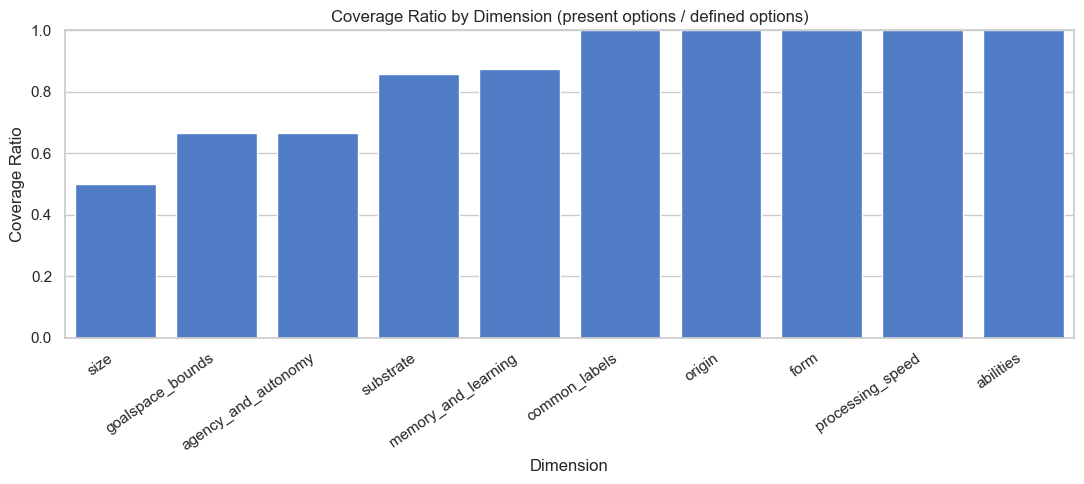

In [8]:
# Visual 1: per-dimension option coverage ratio
plt.figure(figsize=(11, 5))
ax = sns.barplot(data=coverage_df, x="dimension", y="coverage_ratio", color="#3c78d8")
ax.set_ylim(0, 1)
ax.set_title("Coverage Ratio by Dimension (present options / defined options)")
ax.set_xlabel("Dimension")
ax.set_ylabel("Coverage Ratio")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


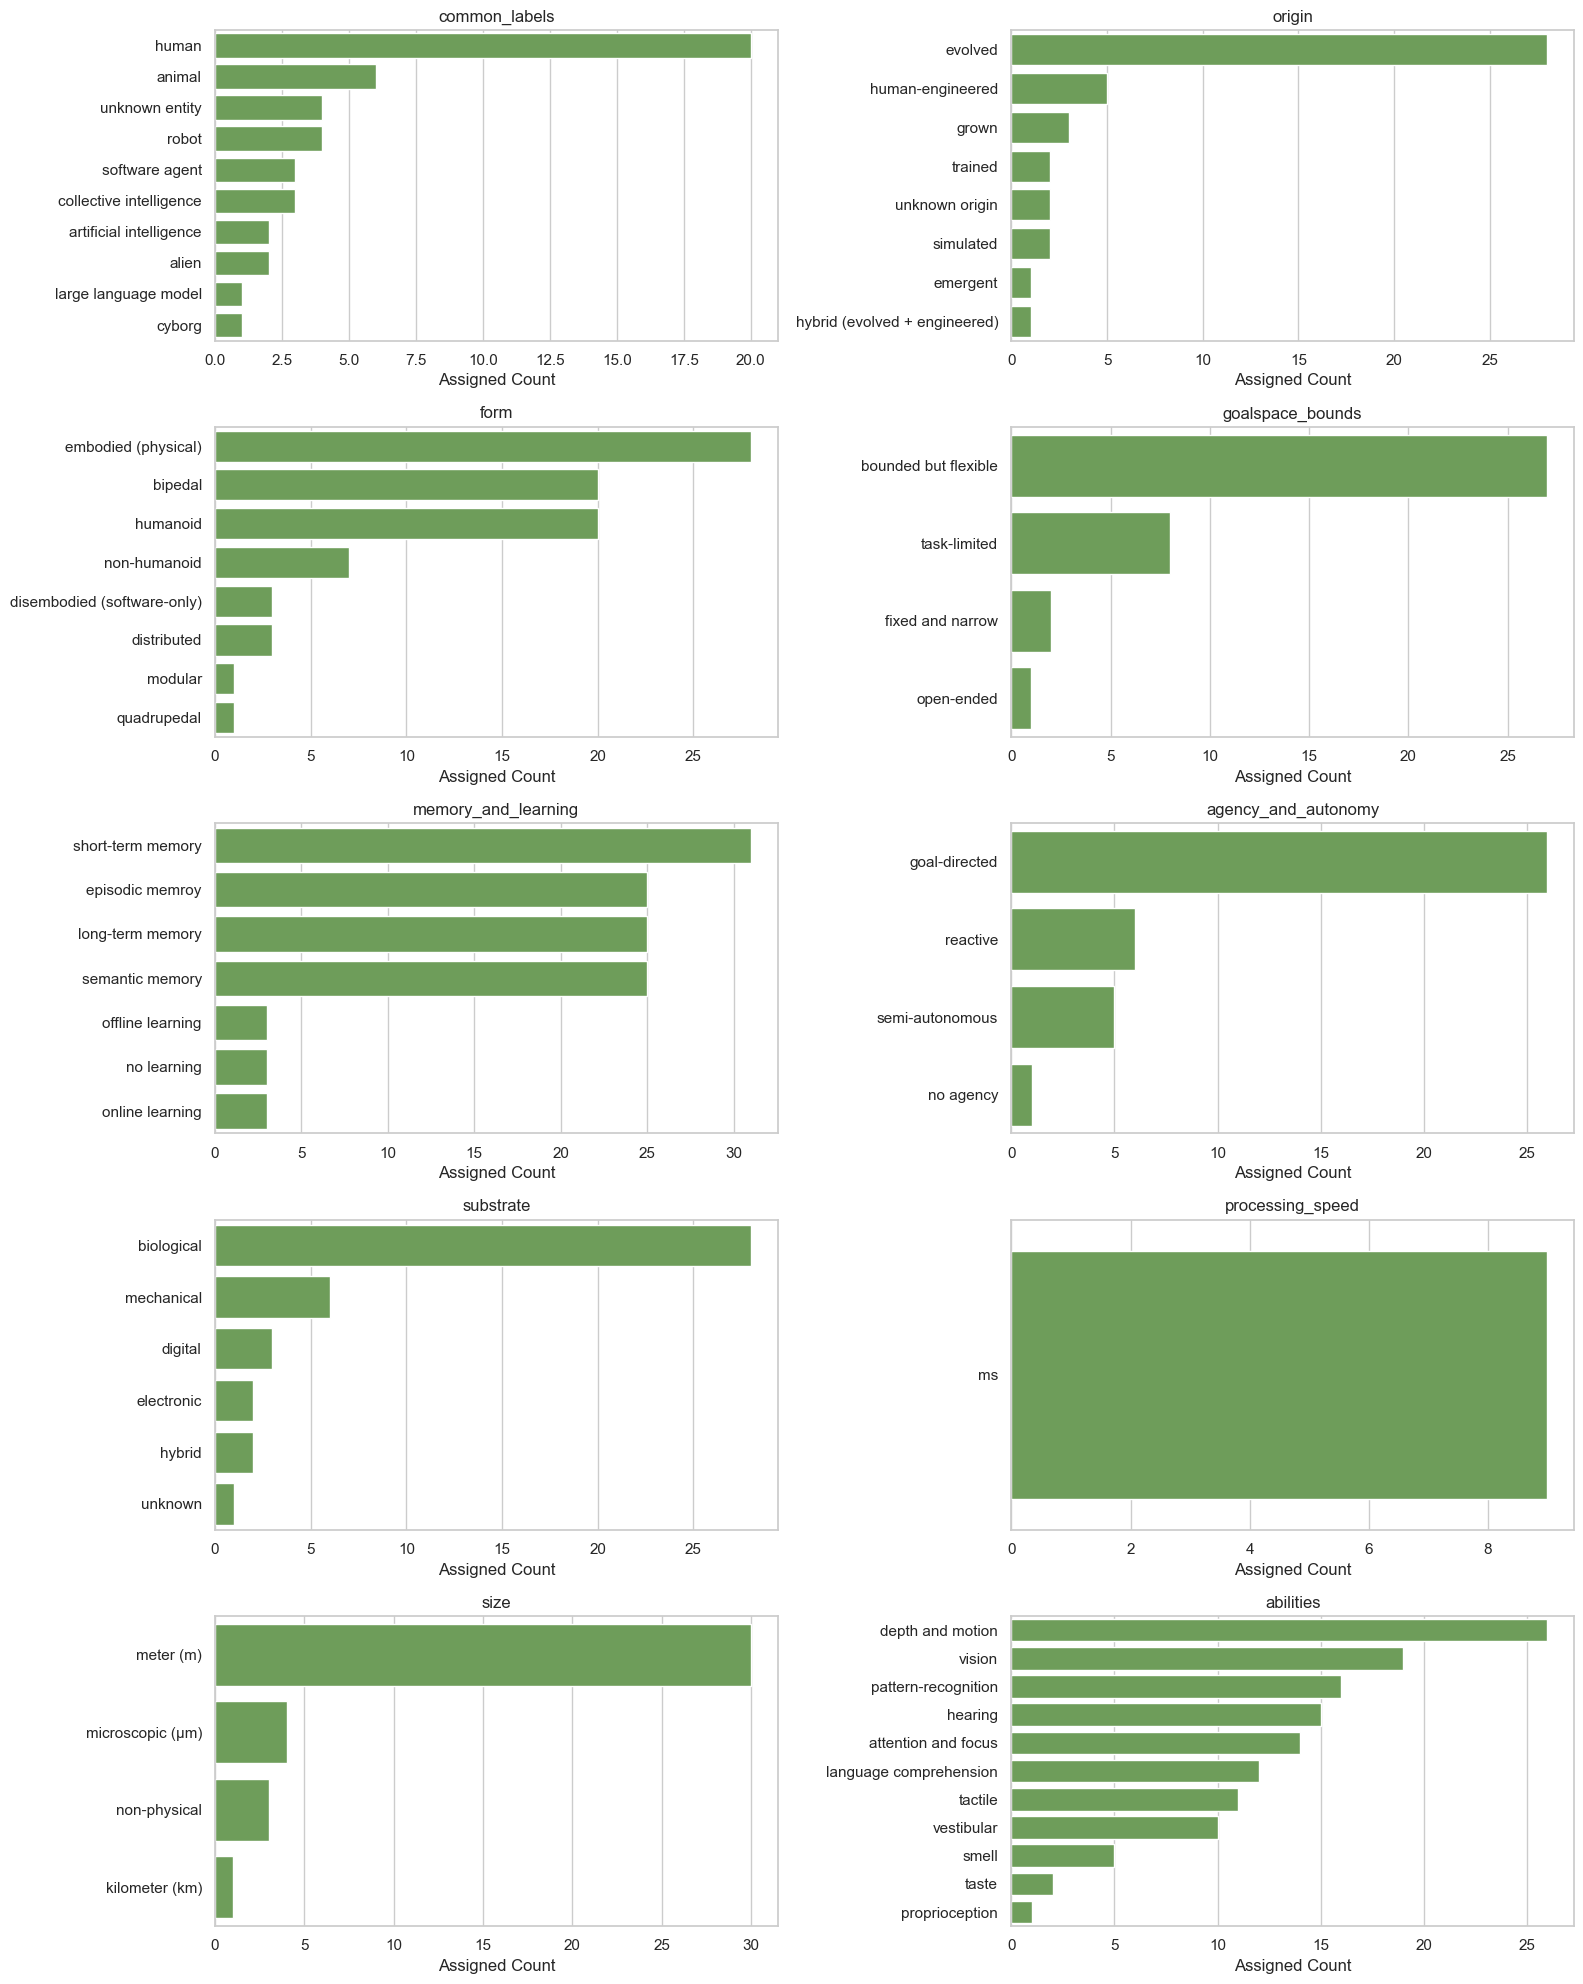

In [9]:
# Visual 2: value distribution for each dimension
plot_df = assignments_df[assignments_df["value"] != "<unmapped>"].copy()

n_dims = len(dimensions)
ncols = 2
nrows = (n_dims + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

for i, dim_name in enumerate(dimensions.keys()):
    subset = (
        plot_df[plot_df["dimension"] == dim_name]["value"]
        .value_counts()
        .rename_axis("value")
        .reset_index(name="count")
    )
    ax = axes[i]
    sns.barplot(data=subset, x="count", y="value", ax=ax, color="#6aa84f")
    ax.set_title(dim_name)
    ax.set_xlabel("Assigned Count")
    ax.set_ylabel("")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


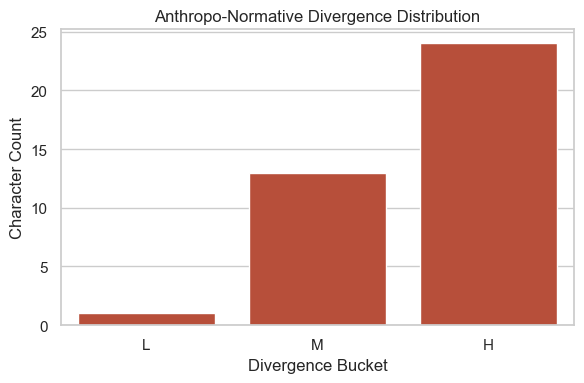

divergence
L     1
M    13
H    24
Name: count, dtype: int64

In [10]:
# Visual 3: divergence distribution (L, M, H)
order = ["L", "M", "H"]
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=divergence_df, x="divergence", order=order, color="#cc4125")
ax.set_title("Anthropo-Normative Divergence Distribution")
ax.set_xlabel("Divergence Bucket")
ax.set_ylabel("Character Count")
plt.tight_layout()
plt.show()

divergence_df["divergence"].value_counts().reindex(order).fillna(0).astype(int)


In [ ]:
# Divergence audit table: label + reason tags for each character
audit_rows = []
for _, row in char_df.iterrows():
    label, reasons = _divergence_label_and_reasons(row)
    audit_rows.append(
        {
            "hid": row["hid"],
            "divergence": label,
            "reason": "; ".join(reasons),
            "descriptors": ", ".join(sorted(row.get("descriptors_norm", set()))),
        }
    )

divergence_audit_df = pd.DataFrame(audit_rows).sort_values(["divergence", "hid"])
divergence_audit_df


,hid,divergence,reason,descriptors
10,algorithm-classifier,H,non-human descriptor set,"algorithm, classifier, computational, non-biological, pattern-recognition, probabilistic"
8,algorithm-sort,H,non-human descriptor set,"algorithm, computational, non-biological, non-human, sorting"
11,alien-collective-unity,H,non-human descriptor set,"alien, biological, collective-intelligence, distributed-mind, hive-like, non-human-cognition"
12,alien-projective-visual,H,non-human descriptor set,"alien, non-human-cognition, non-linguistic, projective-perception, spatial-intelligence, visual-cognition"
13,biological cell,H,non-human descriptor set,"adaptive, biological, cellular, homeostatic, living-system, non-neural-intelligence"
9,dog-robotic-guidedog,H,non-human descriptor set,"assistive-technology, guide, human-facing-interface, mobility-aid, non-biological, robot, sensor-driven"
14,embryo-frog,H,non-human descriptor set,"bioelectric-patterning, biological, cellular-collective, developmental-system, embryonic, non-neural-intelligence"
31,eye-makeup-machine,H,non-human descriptor set,"automation, consumer-device, cosmetics, non-biological, robot, wearable-machine"
6,flatworm,H,non-human descriptor set,"animal, biological, invertebrate"
29,flying-car,H,non-human descriptor set,"evtol, hybrid-mobility, non-biological, street-legal, transportation-system, vehicle"


In [14]:
# Next, I can export each table for manual review / curation if required. 
# assignments_df.to_csv("coverage_assignments.csv", index=False)
# coverage_df.to_csv("coverage_summary.csv", index=False)
# divergence_df.to_csv("divergence_buckets.csv", index=False)


# Futher analysis after meeting with McKinnley.
# To be done!
